# Analyzing NYC High School SAT Scores

--------------------------------------------------------------

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

**In this project I am going to investigate the correlation between SAT scores in NYC high schools and various demographics such as race, gender and income.**

All of the data sets used in this project have been taken from https://data.cityofnewyork.us/.

Here are the details all of the data sets I'll be using:

- **SAT scores by school** - SAT scores for each high school in New York City
https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4

- **School attendance** - Attendance information for each school in New York City
https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt

- **Class size** - Information on class size for each school
https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3

- **AP test results** - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e

- **Graduation outcomes** - The percentage of students who graduated, and other outcome information
https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a

- **Demographics** - Demographic information for each school
https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j

- **School survey** - Surveys of parents, teachers, and students at each school
https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8

Basic research into New York, SAT's and the data has led to the following information:

- Only high school students take the SAT, so I'llfocus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN, or district borough number.
- Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

**To start with I am going to read the various data sets into pandas dataframes.**

# Read in the data

In [1]:
# Import necessary modules
import pandas as pd
import numpy
import re
pd.set_option('display.max_columns', None)

# list of data set names
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Loop through data sets read into pandas dataframe, rename and add to a dictionary for ease of access.
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

data

{'ap_2010':         DBN                                         SchoolName  \
 0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
 1    01M450                             EAST SIDE COMMUNITY HS   
 2    01M515                                LOWER EASTSIDE PREP   
 3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
 4    02M296              High School of Hospitality Management   
 ..      ...                                                ...   
 253  31R605                         STATEN ISLAND TECHNICAL HS   
 254  32K545                      EBC-HS FOR PUB SERVICE (BUSH)   
 255  32K552                          Academy of Urban Planning   
 256  32K554               All City Leadership Secondary School   
 257  32K556  Bushwick Leaders High School for Academic Exce...   
 
     AP Test Takers  Total Exams Taken Number of Exams with scores 3 4 or 5  
 0                39                49                                   10  
 1                19       

I now have 6 of the datasets we need but as mentioned above I also have a school survey data set which gives data based on surveys conducted with the parents, students and teachers of NYC.

The surveys are split into 2 different datasets and are a little more complicated as the files are tab delimited and encoded with Windows-1252 encoding.

The surveys are also very large with over 2000 columns. I will also filter our the vast majority of the columns and just leave the columns relating to the information that I need. To decide which columns to keep I read through the survey data dictionary which can be found here https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8.

**Therefore, my next step is to read the surveys into pandas, combine them together, filter out uneeded columns and add the cleaned survey dataset into the data dictionary with the other data sets.**

# Read in the surveys

In [2]:
# Read surveys into pandas dataframe.
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
# Combine surveys together
survey = pd.concat([all_survey, d75_survey], axis=0)

# Rename DBN column to match other datasets.
survey["DBN"] = survey["dbn"]

# Filter out uneeded columns
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",]
survey = survey.loc[:,survey_fields]
# Add survey dataset to data dictionary
data["survey"] = survey

**The column names in survey refer to the following:**

| Column | Meaning |
| ------ | ------- |
| rr_s | Student Response Rate |
| rr_t | Teacher Response Rate |
| rr_p |	Parent Response Rate |
| N_s |	Number of student respondents |
| N_t |	Number of teacher respondents |
| N_p |	Number of parent respondents |
| nr_s |	Number of eligible students |
| nr_t |	Number of eligible teachers |
| nr_p |	Number of eligible parents |
| saf_p_10 |	Safety and Respect score based on parent responses |
| com_p_10 |	Communication score based on parent responses |
| eng_p_10 |	Engagement score based on parent responses |
| aca_p_10 |	Academic expectations score based on parent responses |
| saf_t_10 |	Safety and Respect score based on teacher responses |
| com_t_10 |	Communication score based on teacher responses |
| eng_t_10 |	Engagement score based on teacher responses |
| aca_t_10 |	Academic expectations score based on teacher responses |
| saf_s_10 |	Safety and Respect score based on student responses |
| com_s_10 |	Communication score based on student responses |
| eng_s_10 |	Engagement score based on student responses |
| aca_s_10 |	Academic expectations score based on student responses |
| saf_tot_10 |	Safety and Respect total score |
| com_tot_10 |	Communication total score |
| eng_tot_10 |	Engagement total score |
| aca_tot_10 |	Academic Expectations total score |


**Now that the datasets are all safely into the data dictionary I now need to start preparing to combine the 7 different data sets into one combined dataset.**

To do this I need a column of unique values which appears in each data set and can be used as the key to merge all the datasets together. 

After browsing the data the obvious column is the DBN column. DBN is a unique identification code that each school has and is made up of the school district and a unique school code. Most of our data sets have a DBN column but the hs_directory data set has the DBN column name in lowercase and the class_size has no DBN column all together. However, the class_size data set does have the information we need split between the 'CSD' column and the 'SCHOOL CODE' columns. **I will therefore make a DBN column in the class_size data set by adding the CSD column to the SCHOOL CODE column. Some of the values will also be needed to padded with a zero if they are 1 digit short of the DBN format. I will also convert the dbn column in hs_directory to upper case.**

# Add DBN columns

In [3]:
# Convert DBN column name to uppercase
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Function to pad values with zero
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
# Apply function 
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Create DBN column in class_size
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"]

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27606,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,US History & Government,-,256.0,10.0,25.6,15.0,35.0,STARS,NaN,32,32K564
27607,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,Economics,-,65.0,2.0,32.5,32.0,33.0,STARS,NaN,32,32K564
27608,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,Participation in Government,-,53.0,2.0,26.5,25.0,28.0,STARS,NaN,32,32K564
27609,32,K,K564,Bushwick Community High School,09-12,CTT,MATH,Integrated Algebra,-,50.0,2.0,25.0,25.0,25.0,STARS,NaN,32,32K564


**I now have a DBN column in each dataset.**

Now we're almost ready to combine our data sets. Before I do, let's take some time to calculate variables that will be useful in our analysis. I've already discussed one such variable -- a column that totals up the SAT scores for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because I'll be working with a single number, rather than three different ones.

Before I can generate this column, **I'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results data set from the object (string) data type to a numeric data type**. I can use the pandas.to_numeric() method for the conversion. If I don't convert the values, I won't be able to add the columns together.

I also want to parse the latitude and longitude coordinates for each school. This will enable me to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory data set. **I will therefore extract the longitude and latitude for each school and add them into new columns called 'lat' and 'lon'.**


# Convert columns to numeric

In [4]:
# Convert string values to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Add sat scores together and assig to sat_score column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Function to find latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Function to find longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Apply function and create new columns
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Convert lon and lat to numeric values
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

data["hs_directory"]

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,"Bx13, Bx15, Bx17, Bx21, Bx35, Bx4, Bx41, Bx4A,...","2, 5 to Intervale Ave",1110 Boston Road,Bronx,NY,10456,www.hsvd.org,378.0,Morris Educational Campus,NaN,The High School for Violin and Dance (HSVD) is...,Freshmen take both violin and dance; College N...,Spanish,NaN,NaN,NaN,Advancement via Individual Determination (AVID...,"Baseball, Basketball & JV Basketball, Volleyball","Basketball, Softball, Volleyball",NaN,Morris Educational Campus Basketball and Volle...,McGraw Hill - Big Brother Big Sister,NaN,"Hostos Community College, Monroe College, Teac...",Bronx Arts Ensemble,buildOn,Print International,NaN,Bronx Cares,Our students are required to take four years o...,"Student Summer Orientation, Summer Internship ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Bronx students or residents who at...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,"Bx1, Bx11, Bx13, Bx18, Bx2, Bx3, Bx32, Bx35, Bx36","4 to Mt Eden Ave ; B, D to 170th St",1501 Jerome Avenue,Bronx,NY,10452,http://schools.nyc.gov/schoolportals/09/X327,543.0,DOE New Settlement Community Campus,NaN,At the Comprehensive Model School Project (CMS...,"After-school and Saturday Tutoring, Advisory, ...",Spanish,"Biology, Chemistry, United States History",NaN,NaN,"Choir, Gaming, Girls Club, Newspaper, Spanish,...",NaN,NaN,NaN,"As we expand, we plan to offer PSAL sports.",New Settlement Community Center,Montefiore Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Dress Code Required: white or baby blue button...,NaN,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Bronx students or residents who attend...,

As mentioned above I will be using the DBN column to combined the datasets. Each column now has a DBN column but some of the datasets have duplicate DBN values. Basically multiple rows have the same DBN value and we need each DBN value to be unique.

While the main data set I want to analyze, sat_results, has unique DBN values for every high school in New York City, other data sets aren't as clean. A single row in the sat_results data set may match multiple rows in the class_size data set, for example. This situation will create problems, because I don't know which of the multiple entries in the class_size data set I should combine with the single matching entry in sat_results. 


**To resolve this issue, I'll condense the class_size, graduation, and demographics data sets so that each DBN is unique.**

**The first data set that I'll condense is class_size.**  It looks like each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY). Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12. Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED. 

**For the demographics data set the only column that prevents a given DBN from being unique is schoolyear.** We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

**Finally, the graduation data set.** The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, I want to pick data from the most recent Cohort available, which is 2006. I also want data from the full cohort, so I'll only pick rows where Demographic is Total Cohort.

# Condense datasets

In [5]:
# Condense class_size data set
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Condense demographics data set
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Condense graduation data set
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

I'm almost ready to combine all of the data sets. The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. **To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.**

# Convert AP scores to numeric

In [6]:
# Convert AP scores to numeric values
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
data["ap_2010"]

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN
...,...,...,...,...,...
253,31R605,STATEN ISLAND TECHNICAL HS,528.0,905.0,809.0
254,32K545,EBC-HS FOR PUB SERVICE (BUSH),47.0,64.0,13.0
255,32K552,Academy of Urban Planning,76.0,100.0,10.0
256,32K554,All City Leadership Secondary School,7.0,8.0,NaN


**I am now ready to combine the 7 data sets together! The new combined data set with conveniently be called 'combined'.**

# Combine the datasets

In [7]:
# Move "sat_results" into combiend
combined = data["sat_results"]

# Merge combined with "ap_2010" and "graduation"
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# Merge remaining data sets
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Fill null values in combined data set
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# First 5 rows of combined data set
combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0.0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNI

In [8]:
# Information about combined dataset
combined.describe(include="all")

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
count,363,363,363,363.000000,363.000000,363.000000,363.000000,363.0,363.000000,363.000000,363.000000,363,363.0,363,363.000000,363.0,363.0,363.0,363.0,363.0,363,363,363,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.0,363,363.0,363.0,363.000000,363.000000,363,363,363,363,363,363,363,363,363,363,363,363,363,363,363.000000,363.000000,363.000000,363.000000,363,363,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363,363,363,363,363,363,363,363.0,363.0,363.0,363,363.0,363,363,363,363.000000,363,363.000000,363.0,363.0,363,363,363,363.0,363.0,363.0,363,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363,363,363,363,363,363.000000,363,363,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363,363.000000,363.000000
unique,362,362,159,NaN,NaN,NaN,NaN,229.0,NaN,NaN,NaN,2,310.0,2,NaN,152.0,224.0,147.0,230.0,198.0,93,166,191,128.0,225.0,229.0,73.0,181.0,198.0,95.0,199.0,65.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362,NaN,NaN,NaN,NaN,1,3,3,3,3,3,3,52,54,50,198,178,180,173,NaN,NaN,NaN,NaN,103,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362,362,5,233,357,361,4,NaN,2.0,NaN,215,172.0,233,26,1,NaN,361,NaN,59.0,8.0,362,362,61,262.0,48.0,31.0,362,231.0,225.0,54.0,241.0,308.0,166.0,314.0,279.0,251.0,181.0,64.0,173.0,277.0,71.0,35,52,1,10,2,NaN,62,55,30.0,23.0,7.0,4.0,2.0,NaN,NaN,NaN,233,NaN,NaN


**The combined dataset is now ready for analysis. As seen above we have 363 different schools from across New York.**

**Now that the combined dataset is ready I can move on to finding correlations.** Correlations tell us how closely related two columns are. I'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

An r value falls between -1 and 1. The value tells us whether two columns are positively correlated, not correlated, or negatively correlated. The closer to 1 the r value is, the stronger the positive correlation between the two columns. The closer to -1 the r value is, the stronger the negative correlation (i.e., the more "opposite" the columns are). The closer to 0, the weaker the correlation.

To start with I am going to find the r value for the correlation between each column and the sat_score. 

# Find correlations

In [9]:
# Find correlation between each column and sat_score
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

That is a long list of different correlations. To make things easier to visualize I am going to go through these separately and plot some graphs to make the data easier to read.

Let's start by plotting a bar chart of the correlation between sat_scores and the survey responses given by parents, students and teachers. On the y-axis is the r value and on the x-axis I have changed the column names to the meanings shown in the table above.

# Plotting survey correlations

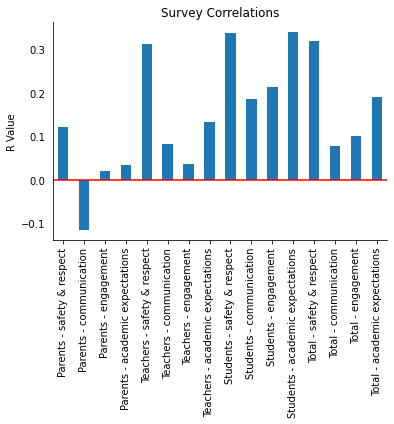

In [10]:
# Remove columns that are not useful for correlation.
survey_correlations = correlations[["saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",]]

# Change column names
survey_correlations = survey_correlations.rename(index={
    "saf_p_11":"Parents - safety & respect", 
    "com_p_11":"Parents - communication", 
    "eng_p_11":"Parents - engagement", 
    "aca_p_11":"Parents - academic expectations",
    "saf_t_11":"Teachers - safety & respect", 
    "com_t_11":"Teachers - communication", 
    "eng_t_11":"Teachers - engagement", 
    "aca_t_11":"Teachers - academic expectations", 
    "saf_s_11":"Students - safety & respect", 
    "com_s_11":"Students - communication", 
    "eng_s_11":"Students - engagement", 
    "aca_s_11":"Students - academic expectations", 
    "saf_tot_11":"Total - safety & respect", 
    "com_tot_11":"Total - communication", 
    "eng_tot_11":"Total - engagement", 
    "aca_tot_11":"Total - academic expectations"})

# Import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Plot bar chart
ax = survey_correlations.plot.bar()
# Set titles and labels
ax.set_ylabel("R Value")
ax.set_title("Survey Correlations")
ax.axhline(color='r')
# Remove top and right spines
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)
# Remove top, right and left tick params
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)

The interesting thing here is that the strongest correlation is between high sat scores and high survey results for safety and respect. In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. Let's have a look at the safety and respect columns in more detail.

An r value isn't perfect, and doesn't indicate that there's a correlation -- just the possiblity of one. **To really assess whether or not a correlation exists, we need to look at the data using a scatterplot to see its "shape."**

# Plotting Safety & Respect vs SAT Scores

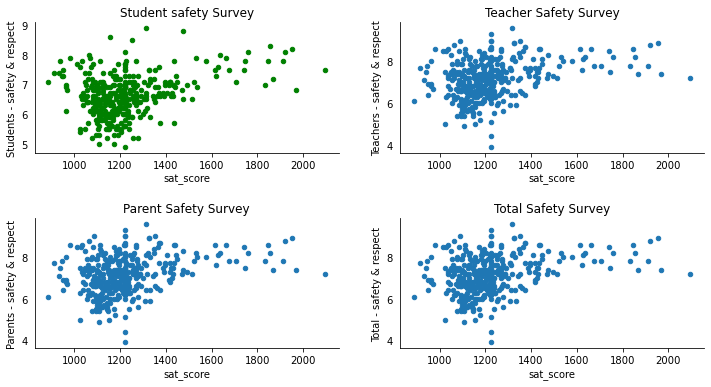

In [11]:
# Create 2x2 grid
fig = plt.figure(figsize=(12,6))
ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,2)
ax_3 = fig.add_subplot(2,2,3)
ax_4 = fig.add_subplot(2,2,4)
fig.subplots_adjust(hspace=0.5)

# Plot scatter chart 1
plot_1 = combined.plot.scatter(y="saf_s_11", x="sat_score", ax=ax_1, c="g")
plot_1.set_ylabel("Students - safety & respect")
plot_1.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
plot_1.set_title("Student safety Survey")
plot_1.spines["right"].set_visible(False)    
plot_1.spines["top"].set_visible(False)    

# Plot scatter chart 2
plot_2 = combined.plot.scatter(y="saf_t_11", x="sat_score", ax=ax_2)
plot_2.set_ylabel("Teachers - safety & respect")
plot_2.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
plot_2.set_title("Teacher Safety Survey")
plot_2.spines["right"].set_visible(False)
plot_2.spines["top"].set_visible(False)    

# Plot scatter chart 3
plot_3 = combined.plot.scatter(y="saf_t_11", x="sat_score", ax=ax_3)
plot_3.set_ylabel("Parents - safety & respect")
plot_3.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
plot_3.set_title("Parent Safety Survey")
plot_3.spines["right"].set_visible(False)
plot_3.spines["top"].set_visible(False)  

# Plot scatter 4
plot_4 = combined.plot.scatter(y="saf_t_11", x="sat_score", ax=ax_4)
plot_4.set_ylabel("Total - safety & respect")
plot_4.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
plot_4.set_title("Total Safety Survey")
plot_4.spines["right"].set_visible(False)
plot_4.spines["top"].set_visible(False)  


For strong correlation the shape we are looking for would be a line from bottom left to top right. Do we have that shape? Not really. However, each of the charts does have a section of schools all bundled up in the top right and nothing in the bottom right. This means that there are no schools with high sat_scores and low safety and respect scores but there are a good number of schools with high sat scores and high safety and respect scores. 

**Let's take a closer look at those schools that have both a high safety and respect score and high sat scores.**

# Plotting Borough Correlations

In [12]:
# Filter high safety and respect scores and high sat scores
high_safety_high_sat = combined[(combined["saf_tot_11"] > 7) & (combined["sat_score"] > 1800) ]
high_safety_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,153.45,Total Cohort,BARD HIGH SCHOOL EARLY COLLEGE,2006,139.0,134,96.4%,134,96.4%,100%,0,0%,0%,134,96.4%,100%,0,0%,0%,4,2.9%,1,0.7%,1,214.166667,10.250000,20.975000,17.166667,24.250000,0.0,BARD HIGH SCHOOL EARLY COLLEGE,20112012,0.0,18.0,617,,,,,,,,,,,184,162,128,143,1.0,0.2,5.0,0.8,0,0,93,15.1,93,15.1,112,18.2,307,49.8,193.0,31.3,424.0,68.7,98.0,81,50,561.0,30.0,283.0,8.8,8.2,8.3,9.1,8.2,7.4,7.5,8.3,8.3,7.3,8.0,8.9,8.5,7.6,8.0,8.7,01M696,Bard High School Early College,Manhattan,M097,212-995-8479,212-777-4702,9,12,0,12.0,"M14A, M14D, M21, M22, M9",0,525 East Houston Street,New York,NY,10002,www.bard.edu/bhsec,560.0,0,0,Bard High School Early College Manhattan (BHSE...,"In the first two years at BHSEC, students unde...","Chinese (Mandarin), Latin, Spanish",0,0,0,"Bard Bulletin online newspaper, Bardvark stude...","Basketball, Soccer, Tennis","Basketball, Soccer, Tennis, Volleyball",Outdoor Track,Co-ed Ultimate Frisbee,"Lower East Side Girls Club, Third Street Music...",0,"Bard College, Bard College at Simon's Rock, Ro...","American Symphony Orchestra, American Museum o...",0,0,0,New York Academy of Sciences,0,Student Summer Orientation,9:00 AM,3:50 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,2648.00,Total Cohort,STUYVESANT HIGH SCHOOL,2006,787.0,774,98.3%,774,98.3%,100%,770,97.8%,99.5%,4,0.5%,0.5%,0,0%,0%,10,1.3%,3,0.4%,2,876.052632,28.000000,31.115789,24.105263,33.842105,0.0,STUYVESANT HIGH SCHOOL,20112012,0.0,30.3,3297,,,,,,,,,,,813,82

My first thought was that the safety and respect score is probably linked to the areas that the schools are in. A low safety score would probably indicate that the school is in a low income area with unfunded schools and students who have gone through a number of social issues. Whereas a high safety score would indicate a high income area with well funded schools, a large proportion of private schools and parents with the income to pay for private tutors etc.

**So, let's take a look at what boroughs our high SAT high safety & respect schools are in.**

In [13]:
high_safety_high_sat["boro"]

5          Manhattan
37         Manhattan
79         Manhattan
151            Bronx
155            Bronx
187         Brooklyn
302           Queens
327           Queens
356    Staten Island
Name: boro, dtype: object

My initial thoughts seem to be incorrect. All 5 boroughs are represented amongst the schools that scored highly for safety & respect and also for SAT scores. However, this is a sample of only 9 schools. I am now going to take a look at the average safety & respect score for each borough and also the average SAT score. I will then see if there is any correlation between the two.

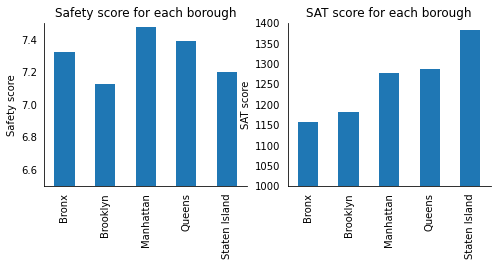

In [14]:
# Create grid
fig = plt.figure(figsize=(8,3))
ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

# Group schools by borough and find mean safety and respect
boro_saf_avg = combined.groupby("boro")["saf_tot_11"].mean()
# Plot bar chart
ax = boro_saf_avg.plot.bar(ax=ax_1)
# Set labels, limits, title and parameters
ax.set_ylim(6.5, 7.5)
ax.set_ylabel("Safety score")
ax.set_xlabel("")
ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=True)
ax.set_title("Safety score for each borough")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)  

# Group schools by borough and find mean safety and respect
boro_sat_avg = combined.groupby("boro")["sat_score"].mean()
# Plot bar chart
ax2 = boro_sat_avg.plot.bar(ax=ax_2)
# Set labels, limits, title and parameters
ax2.set_ylim(1000, 1400)
ax2.set_ylabel("SAT score")
ax2.set_xlabel("")
ax2.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=True)
ax2.set_title("SAT score for each borough")
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False) 

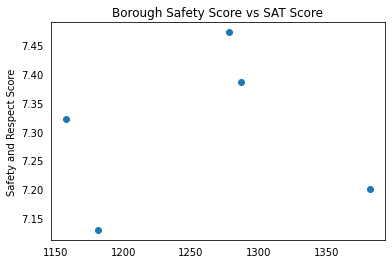

In [15]:
# Plot scatter chart
plt.scatter(x=boro_sat_avg, y=boro_saf_avg)
plt.title("Borough Safety Score vs SAT Score")
plt.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=True)
plt.ylabel("Safety and Respect Score")
plt.show()

These graphs show that there is no correlation between SAT scores and the safety scores of NYC boroughs. Manhatten had the highest safety score but only the third highes SAT score. Meanwhile, Satan Island has by far the highest average SAT score but the second lowest average safety and respect score.

The scatter chart shows this further. The dots are all over the place and show no sign of correlation whatsoever.

**What we can learn from this, however, is that on average the schools in Statin island have the highest average SAT score and that The Bronx schools average the lowest scores.**

After working through the surveys and taking a look at the NYC boroughs my conclusions so far are that the schools where teachers, students and parents feel safe and respected are likely to score better and that the schools in Statin Island are also more likely to score higher.

**I am now going to move onto my next area of analysis: Ethnicity.**

# Plotting Ethnicity vs SAT Scores

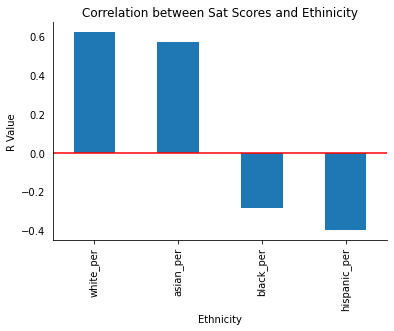

In [16]:
# Filter the columns in correlations relation to ethnicity percentage
ethnicity_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
ethnicity_correlation = correlations[ethnicity_cols]
ethnicity_correlation

# Plot bar chart
ax = ethnicity_correlation.plot.bar()
# Horizontal line ot 0
ax.axhline(c="r")
# Set title, labels and parameters
ax.set_ylabel("R Value")
ax.set_xlabel("Ethnicity")
ax.set_title("Correlation between Sat Scores and Ethinicity")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)

This graph is very clear. With white_per at an R value of 0.6, Asian_per close behind there is a strong possibility of positive correlation between schools that have a high proportion of White and Asian students and high SAT scores. On the opposite end of the spectrum there appears to be negative correlation between schools with a high proportion of Black and Hispanic students and SAT Scores. 

Let's make a scatter graph for each ethinicity to see if the shapes of the graphs match what the R values are telling us in the graph above. For each chart I am including schools that have a majority of a particular ethnicity. 

(800.0, 2200.0)

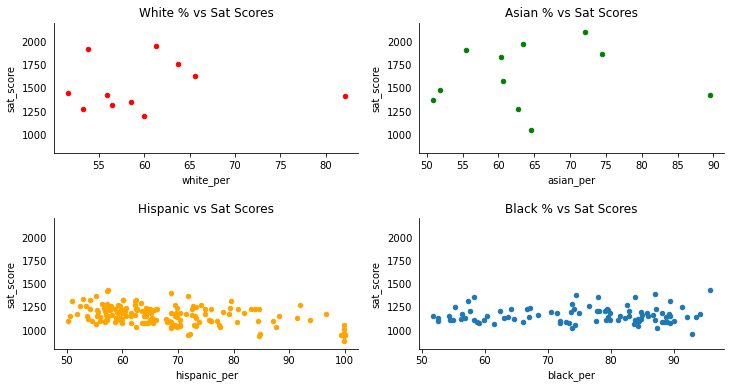

In [17]:
# Plot 2x2 Grid
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
fig.subplots_adjust(hspace=0.5)

# Filter schools that have a majority of each ethinicity
hispanic_above_50 = combined[combined["hispanic_per"] > 50]
black_above_50 = combined[combined["black_per"] > 50]
white_above_50 = combined[combined["white_per"] > 50]
asian_above_50 = combined[combined["asian_per"] > 50]

# Plot scatter chart for majority White schools
white_plot_1 = white_above_50.plot.scatter("white_per", "sat_score", ax=ax1, c="r")
white_plot_1.set_title("White % vs Sat Scores")
white_plot_1.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
white_plot_1.spines["top"].set_visible(False)
white_plot_1.spines["right"].set_visible(False)
white_plot_1.set_ylim(800, 2200)

# Plot Scatter chart for majority Asian schools
asian_plot_1 = asian_above_50.plot.scatter("asian_per", "sat_score", ax=ax2, c="g")
asian_plot_1.set_title("Asian % vs Sat Scores")
asian_plot_1.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
asian_plot_1.spines["top"].set_visible(False)
asian_plot_1.spines["right"].set_visible(False)
asian_plot_1.set_ylim(800, 2200)

# Plot scatter chart for majority Hispanic schools
hispanic_plot_1 = hispanic_above_50.plot.scatter("hispanic_per", "sat_score", ax=ax3, c="orange")
hispanic_plot_1.set_title("Hispanic vs Sat Scores")
hispanic_plot_1.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
hispanic_plot_1.spines["top"].set_visible(False)
hispanic_plot_1.spines["right"].set_visible(False)
hispanic_plot_1.set_ylim(800, 2200)

# Plot scatter chart for majority Black schools
black_plot_1 = black_above_50.plot.scatter("black_per", "sat_score", ax=ax4)
black_plot_1.set_title("Black % vs Sat Scores")
black_plot_1.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
black_plot_1.spines["top"].set_visible(False)
black_plot_1.spines["right"].set_visible(False)
black_plot_1.set_ylim(800, 2200)

These charts confirm what we saw in the above bar charts. There were no majority Black or Hispanic schools that averaged above 1500 in the SATS whereas 36% of majority White schools average above 1500 and 55% of mjority Asian schools scored above 1500.

These results are indisputable. The majority White and Asian schools perform far better than the majority Black and Hispanic schools.

The next demographic that I am going to look at is Gender.

# Plotting Gender vs Sat Scores

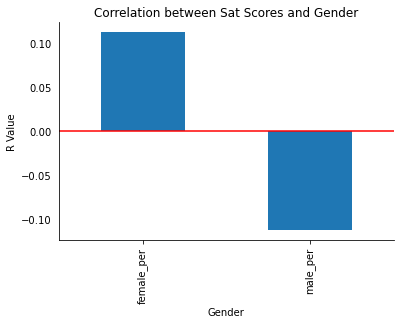

In [18]:
# Filter gender columns
sex_cols = ["female_per", "male_per"]
sex_correlations = correlations[sex_cols]

# Plot Bar chart
ax = sex_correlations.plot.bar()
ax.axhline(c="r")
ax.set_ylabel("R Value")
ax.set_xlabel("Gender")
ax.set_title("Correlation between Sat Scores and Gender")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)

Here we have a positive correlation for female percentage and negative correlation for male percentage. However, the correlation is very small. Remember I said before that for there to be correlation the R value should be above 0.25. In this case a correlation of 0.1 doesn't really show us very much.

I am going to plot the gender data into a couple of scatter charts to see if the shape of the charts indicate a greater correlation than the R value indicates. 

(-1.0, 101.0)

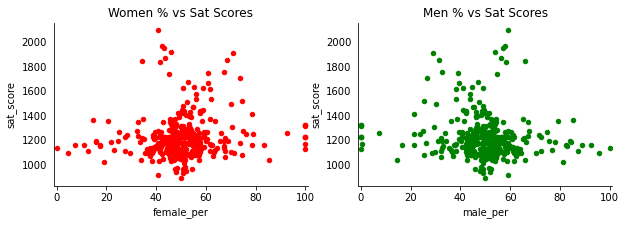

In [19]:
# Plot 1x2 grid
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Plot Female chart
women_plot = combined.plot.scatter("female_per", "sat_score", ax=ax1, c="r")
women_plot.set_title("Women % vs Sat Scores")
women_plot.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
women_plot.spines["top"].set_visible(False)
women_plot.spines["right"].set_visible(False)
women_plot.set_xlim(-1,101)

# Plot Male chart
men_plot = combined.plot.scatter("male_per", "sat_score", ax=ax2, c="g")
men_plot.set_title("Men % vs Sat Scores")
men_plot.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
men_plot.spines["top"].set_visible(False)
men_plot.spines["right"].set_visible(False)
men_plot.set_xlim(-1,101)

Again these scatter charts don't show us a whole lot. The female percentage had a higher R value but it is low and the scatter charts do not indicate much correlation so I am not going to read much into the Gender difference in SAT scores. 

I am going to move on and look at the percentage of students who are on the AP program. Remember that High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

As AP exams are typically in schools that have higher funding and greater academic rigor I am expecting there to be a strong positive correlation and that schools that have a high proportion of AP students to score very well in SAT exams.

# Plotting AP percentage vs SAT Scores

(-1.0, 101.0)

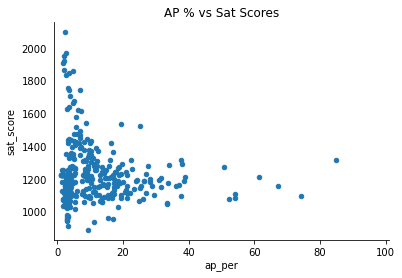

In [20]:
# Create AP percentage column
ap_per = combined["total_enrollment"] / combined["AP Test Takers "] 
combined["ap_per"] = ap_per

# Plot scatter chart for AP % vs SAT Score
ax = combined.plot.scatter("ap_per", "sat_score")
# Set title, tick params and x limits
ax.set_title("AP % vs Sat Scores")
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(-1,101)

This is very interesting. There appears to be no correlation at all between the percent of AP classes and success in the SAT exams. Remember AP classes are much rarer in unfunded schools and those that are typically seen as being underperforming. However, when it comes to the SAT's it appears that the percent of AP classes has no affect on success.

Perhaps, students spend more time focussing on their AP classes and exams and therefore neglect the SAT's. 

**The final analysis I will do is a look at the correlation between class size and sat scores. I am expecting a negative correlation and that the lower the class size the better the SAT scores.**

# Plotting Class Size vs Sat Score

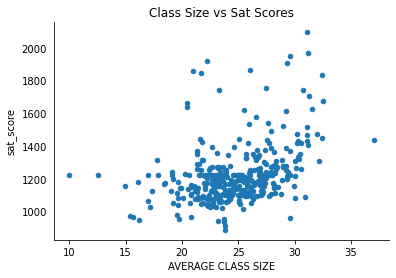

In [21]:
# Plot scatter chart for class size vs Sat Score
ax = combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")
# Set title and tick parameters
ax.set_title("Class Size vs Sat Scores")
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

This is another surprising scatter chart. I was expecting there to be negative correlation and that the smaller the class size the better the SAT scores. This seems logical as smaller class size means more focus on each individual student. However, **the chart above shows that there is actually a correlation between large class sizes and better SAT scores.**

I did a little research and found that large class sizes producing better test results is something that has come up across the USA, in the Uk and in Germany as well. Asian countries like China, South Korea and Japan also have large average classroom sizes and have traditionally always produced strong test scores.

A couple of theories for why this may be:

- Large classes reduce teacher to student interaction and instead encourages critical thinking, independence and team work with classmates.
- Large classes reduce the variety of activites that can be done in the class and results in activites that are centered on memorization, repitition and bookwork. Skills that may translate well with exam taking.
- Large class sizes reduce costs and allow funds to be allocated into other areas such as equipment and materials.

# Conclusions

- The best way to ensure that you are going to send your child to a high school in New York with high SAT scores is to send them to a school with a high proportion of White and Asian students. Is this because they are smarter or work harder? No. This is connected to the economic and social issues in America. As unfair as it may be, schools that have a high proportion of Black and Hispanic students are likley to perform worse in SAT exams. Schools with large numbers of Black and Hispanic students are more likley to be unfunded, in low income areas whilst the students are more likley to have issues at home and less likely to have the benefits of extra tution and private education etc.

- Schools that are considered to be safe and respectful by teachers, students and parents are more likley to perform better in SAT exams. High SAT scores are linked more closely to the safety and respect of schools than communication, engagement and academic expectations. 

- Schools with a higher proportion of females perform slightly better than majority male schools but the difference is small and gender is nowhere near as important to a schools SAT performance as ethnicicty.

- The NYC Borough with the highest performing schools is Satin Island and the lowest performing schools is The Bronx.

- Schools that have a higher proportion of AP students do not perform better in SAT exams. 

- Schools that have higher class sizes actually perform better in SAT exmas than those that have smaller class sizes. This was a big surprise and upon further research is something that is not just confined to NYC. Perhaps, the idea of smaller class sizes = academic success is not as accurate as previously thought. 